In [16]:
import calendar
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from datetime import timedelta, date

###### casper_2020
 - Annual hottest day of Year time series
 - Annual hottest night of Year time series
 - Annual JJA mean time series 
 - Annual number of day >90
 
 This is for comparison with Paul's 'Climatological Context for Portland' 

In [28]:
# Boolean indexing 
# create a range of dates list 
# convert dates list to pandas Datetime index pd.todatetime(df.date)

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

        
def rd_ts(dir_i, var_s): 
    flnm = dir_i + var_s + "_1981-2021.csv"
    print('read in ', flnm)
 
    df = pd.read_csv(flnm)

    # convert date column to DateTime
    df['date'] = pd.to_datetime(df.date)

    # note: convert index to DatetimeIndex so I can use groupby year later on
    df.index =  pd.to_datetime(df.date)
    
    return df

'''
def plot_trend(df, ax):
   
    z = np.polyfit(df.index, df.Washington, 1)
    p = np.poly1d(z)
    ax.yaxis.set_ticks_position('both')
    ax.plot(df.index, p(df.index))
'''

def plot_trend(df,ax): 
    '''
    add a trend line to dataframe plot
    '''
    #import scipy 
    
    z1 = np.polyfit(df.index, df.Washington, 1)
    z2 = np.polyfit(df.index, df.Multmomah, 1)
    z3 = np.polyfit(df.index, df.Clackamas, 1)
    
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)

    ax.yaxis.set_ticks_position('both') 
    ax.plot(df.index, p1(df.index), color='green', linestyle='dashed', linewidth=1)
    ax.plot(df.index, p2(df.index), color='orange', linestyle='dashed',linewidth=1)
    ax.plot(df.index, p3(df.index), color='blue', linestyle='dashed', linewidth=1)  
    plt.xlim(df.index[0], df.index[-1]) 
    
    # output formatting
    print('----')
    slope, intercept, r, p, se = stats.linregress(df.index, df.Washington)
    print('Washington: %5.3f, slope: %5.3f, p_value: %5.3f' % (p1(df.index)[-1]-p1(df.index)[0], slope, p))
    slope, intercept, r, p, se = stats.linregress(df.index, df.Multmomah)
    print('Multmomtn: %5.3f, slope: %5.3f, p_value: %5.3f' % (p2(df.index)[-1]-p2(df.index)[0],  slope, p))
    slope, intercept, r, p, se = stats.linregress(df.index, df.Clackamas)
    print('Clackamas: %5.3f, slope: %5.3f, p_value: %5.3f' % (p3(df.index)[-1]-p3(df.index)[0],  slope, p))
    
def df_n_quantile(df, df_year, p_quantile, is_exceed):
    '''
    df:
    df_year: DataFrame of number of days > or < p_quantile
             of 5 variables 
    p_quantile: quantile 0-1
    is_exceed: 
        True > p_quantile
        False < p_quantile
    '''
    
    name_col = df.columns
    n_loc = 5
    p_qtile = df.quantile(p_value)  
    if p_quantile == 0.0:
        p_qtile[:] = 0.1
        
    ## note: quantile works on all 4 number columns
    #print("quantile:")
    #print(p_qtile)
    #print("")

    for count in range(0, n_loc):
        #print("works on", name_col[count+3])
        
        if is_exceed:
            obj_p = df.loc[:, name_col[count+3]] > p_qtile[count+1] 
        else:
            obj_p = df.loc[:, name_col[count+3]] < p_qtile[count+1] 
     
        # Boolean indexing  obj_p[obj_p]
        # number of true for each year obj.groupby(lambda x: x.year).size()
        # x means df.index 'datetime' we converted to
        # groupby(lambda x: x.year).size()
        # equivalent to:
        # def func(date):
        #     return date.year
        # df.groupby(func).size()

        ser_0 = obj_p[obj_p].groupby(lambda x: x.year).size()
     
        for year in range(df.year[0], df.year[-1]+1, 1):
            try:
            # get a list of columns: list(df)
              # get a list of particular column list(df)[count]
                df_year[list(df_year)[count]][year] = ser_0[year]
            except: 
                df_year[list(df_year)[count]][year] = 0
                
    return df_year

def get_season(df, season_s, method):
    '''
    season_s:  'DJF', 'MAM', 'JJA', 'SON'
    method: 'mean', 'max', 'min'
    '''
    name_col = df.columns
    print(name_col[3:8])
    # create a new DataFrame
    ser = pd.Series(0, index = range(df.year[0], df.year[-1]+1))
    data = {name_col[3]:ser, name_col[5]:ser, name_col[6]:ser}
    df_year = pd.DataFrame(data) 
    group_MAM = df.groupby(['season']).get_group(season_s)
    if method=='mean':
        t_mam=group_MAM.groupby(lambda x: x.year).mean()
    elif method=='max':
        t_mam=group_MAM.groupby(lambda x: x.year).max()
    elif method=='min':
        t_mam=group_MAM.groupby(lambda x: x.year).min()    
    
    df_year['Washington']=t_mam.Washington 
    df_year['Multmomah']=t_mam.Multmomah 
    df_year['Clackamas']=t_mam.Clackamas
    #df_year['Columbia']=t_mam.Columbia
    #df_year['Yamhill']=t_mam.Yamhill
    
    ## For trend
    z = np.polyfit(df_year.index, df_year.mean(axis=1), 1)
    p = np.poly1d(z)
    # return list     
    return [df_year,p]  

def plot_seasonal_ts(df_tmax, method):
    '''
    method: 'mean', 'max', 'min'
    '''
    fig, ax = plt.subplots(2, 2,figsize=(12,6))
    
    [df_year,p] = get_season(df_tmax, 'DJF', method)
    pd.DataFrame(df_year).plot(title='DJF', ax=ax[0,0])
    plot_trend(pd.DataFrame(df_year), ax=ax[0,0])
    

    [df_year,p]=get_season(df_tmax,'MAM', method)
    pd.DataFrame(df_year).plot(title='MAM',ax=ax[0,1])
    plot_trend(df_year, ax=ax[0,1])
     

    [df_year,p]=get_season(df_tmax, 'JJA', method)
    pd.DataFrame(df_year).plot(title='JJA',ax=ax[1,0])
    plot_trend(df_year, ax=ax[1,0])
     

    [df_year,p]=get_season(df_tmax, 'SON', method)
    pd.DataFrame(df_year).plot(title='SON',ax=ax[1,1])
    plot_trend(df_year, ax=ax[1,1])
     
    

In [30]:
dir_i = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/'

df_tmax = rd_ts(dir_i, 'Tmax')
df_tmin = rd_ts(dir_i, 'Tmin')
df_prec = rd_ts(dir_i, 'PR')

year_s = df_tmax.year[0]
year_e = df_tmax.year[-1]

# get column name by df.columns
name_col = df_tmax.columns
name_col

read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/Tmax_1981-2021.csv
read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/Tmin_1981-2021.csv
read in  /glade/campaign/mmm/c3we/mingge/INNOVATOR/DATA/PR_1981-2021.csv


Index(['date', 'year', 'season', 'Clackamas', 'Columbia', 'Multmomah',
       'Washington', 'Yamhill'],
      dtype='object')

In [31]:
# for Clackamas	Multmomah	Washington
id_col = [3, 5, 6]
n_loc = len(id_col)

# create a new DataFrame
ser = pd.Series(0, index = range(year_s, year_e+1))
data = {name_col[id_col[0]]:ser, name_col[id_col[1]]:ser, name_col[id_col[2]]:ser}
df_year = pd.DataFrame(data) 
df_year.head()
 

,Clackamas,Multmomah,Washington
1981,0,0,0
1982,0,0,0
1983,0,0,0
1984,0,0,0
1985,0,0,0


####  Annual Number of Days over 90 Degrees

----
Washington: 2.362, slope: 0.059, p_value: 0.299
Multmomtn: 1.937, slope: 0.048, p_value: 0.474
Clackamas: 2.300, slope: 0.057, p_value: 0.269


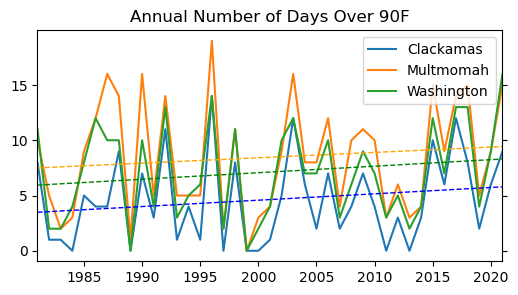

In [33]:
for count in range(n_loc):
    obj_p = df_tmax.loc[:, name_col[id_col[count]]] > 32.2222  #90F
    ser_0 = obj_p[obj_p].groupby(lambda x: x.year).size()
    for year in range(df_tmax.year[0], df_tmax.year[-1]+1, 1):
            try:
            # get a list of columns: list(df)
              # get a list of particular column list(df)[count]
                df_year[list(df_year)[count]][year] = ser_0[year]
            except: 
                df_year[list(df_year)[count]][year] = 0
                
fig, ax = plt.subplots(1, 1, figsize=(6,3))

df_year.plot(title='Annual Number of Days Over 90F', ax=ax) 
plot_trend(df_year,ax) 

----
Washington: 4.237, slope: 0.106, p_value: 0.232
Multmomtn: 4.885, slope: 0.122, p_value: 0.221
Clackamas: 6.014, slope: 0.150, p_value: 0.083


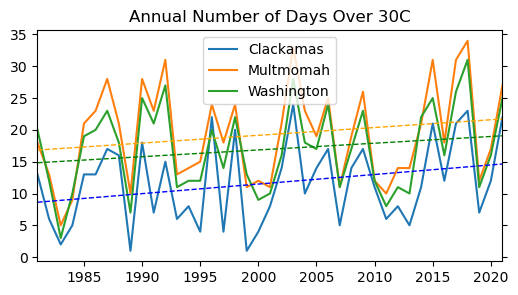

In [34]:
for count in range(n_loc):
    obj_p = df_tmax.loc[:, name_col[id_col[count]]] > 30  #90F
    ser_0 = obj_p[obj_p].groupby(lambda x: x.year).size()
    for year in range(df_tmax.year[0], df_tmax.year[-1]+1, 1):
            try:
            # get a list of columns: list(df)
              # get a list of particular column list(df)[count]
                df_year[list(df_year)[count]][year] = ser_0[year]
            except: 
                df_year[list(df_year)[count]][year] = 0
                
fig, ax = plt.subplots(1, 1, figsize=(6,3))

df_year.plot(title='Annual Number of Days Over 30C', ax=ax) 
plot_trend(df_year,ax) 

#### Hottest Day of Year

----
Washington: 1.188, slope: 0.030, p_value: 0.553
Multmomtn: 1.028, slope: 0.026, p_value: 0.596
Clackamas: 2.052, slope: 0.051, p_value: 0.304


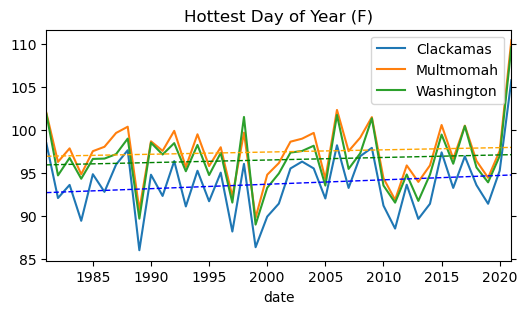

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_tmaxF = df_tmax[[name_col[id_col[0]], name_col[id_col[1]],name_col[id_col[2]]]].groupby(lambda x: x.year).max()* 9/5 + 32
df_tmaxF.plot(title='Hottest Day of Year (F)', ax = ax)
plot_trend(df_tmaxF,ax) 

----
Washington: 0.660, slope: 0.017, p_value: 0.553
Multmomtn: 0.571, slope: 0.014, p_value: 0.596
Clackamas: 1.140, slope: 0.028, p_value: 0.304


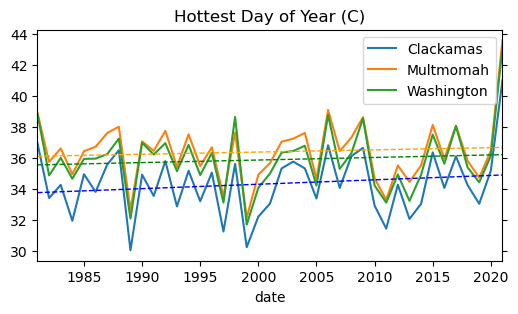

In [37]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_tmaxC = df_tmax[[name_col[id_col[0]], name_col[id_col[1]],name_col[id_col[2]]]].groupby(lambda x: x.year).max()
df_tmaxC.plot(title='Hottest Day of Year (C)', ax = ax)
plot_trend(df_tmaxC,ax)

#### Hottest Night of Year

----
Washington: 4.291, slope: 0.107, p_value: 0.008
Multmomtn: 4.097, slope: 0.102, p_value: 0.006
Clackamas: 3.438, slope: 0.086, p_value: 0.037


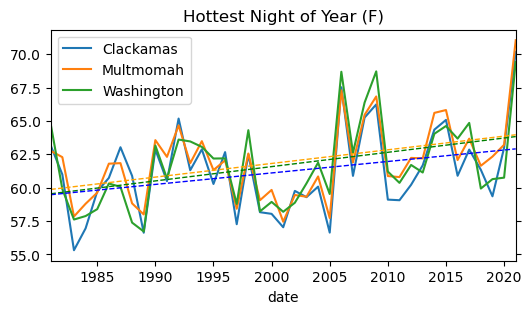

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_tminF = df_tmin[[name_col[id_col[0]], name_col[id_col[1]],name_col[id_col[2]]]].groupby(lambda x: x.year).max()* 9/5 + 32
df_tminF.plot(title='Hottest Night of Year (F)', ax = ax)
plot_trend(df_tminF,ax) 

#### Seasonal mean Tmax

Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 0.064, slope: 0.002, p_value: 0.893
Multmomtn: -0.033, slope: -0.001, p_value: 0.944
Clackamas: 0.549, slope: 0.014, p_value: 0.244
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: -0.121, slope: -0.003, p_value: 0.849
Multmomtn: -0.227, slope: -0.006, p_value: 0.728
Clackamas: 0.334, slope: 0.008, p_value: 0.624
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 1.306, slope: 0.033, p_value: 0.044
Multmomtn: 1.227, slope: 0.031, p_value: 0.067
Clackamas: 1.835, slope: 0.046, p_value: 0.009
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 0.126, slope: 0.003, p_value: 0.818
Multmomtn: -0.141, slope: -0.004, p_value: 0.807
Clackamas: 0.502, slope: 0.013, p_value: 0.429


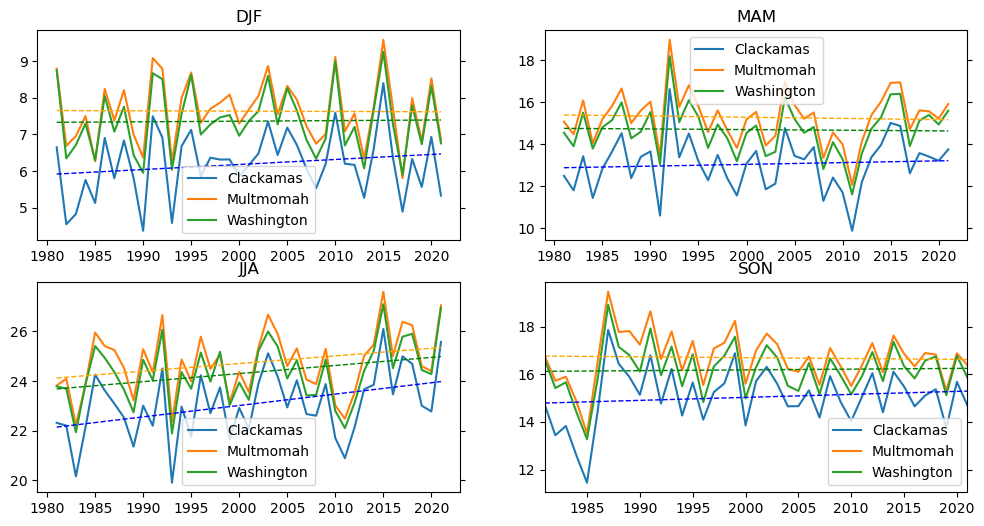

In [40]:
plot_seasonal_ts(df_tmax, 'mean');

Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 0.704, slope: 0.018, p_value: 0.401
Multmomtn: 1.266, slope: 0.032, p_value: 0.097
Clackamas: 1.407, slope: 0.035, p_value: 0.045
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: -0.094, slope: -0.002, p_value: 0.914
Multmomtn: -0.441, slope: -0.011, p_value: 0.583
Clackamas: -0.232, slope: -0.006, p_value: 0.816
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 2.591, slope: 0.065, p_value: 0.005
Multmomtn: 2.397, slope: 0.060, p_value: 0.004
Clackamas: 2.115, slope: 0.053, p_value: 0.023
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 1.332, slope: 0.033, p_value: 0.050
Multmomtn: 1.213, slope: 0.030, p_value: 0.084
Clackamas: 0.936, slope: 0.023, p_value: 0.277


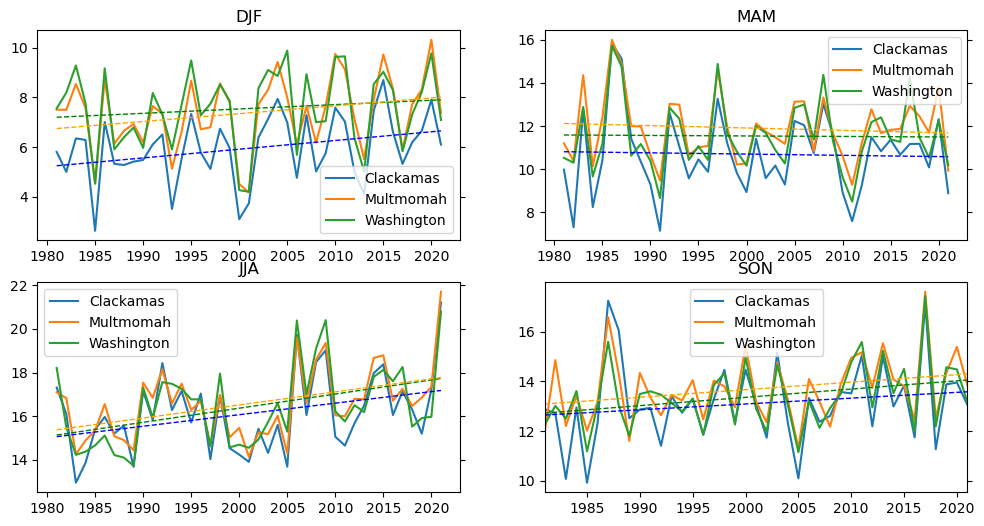

In [41]:
plot_seasonal_ts(df_tmin, 'max');

Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 1.004, slope: 0.025, p_value: 0.250
Multmomtn: 0.928, slope: 0.023, p_value: 0.290
Clackamas: 1.433, slope: 0.036, p_value: 0.091
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 0.405, slope: 0.010, p_value: 0.658
Multmomtn: 0.194, slope: 0.005, p_value: 0.838
Clackamas: 0.778, slope: 0.019, p_value: 0.444
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 2.637, slope: 0.066, p_value: 0.003
Multmomtn: 2.538, slope: 0.063, p_value: 0.005
Clackamas: 3.079, slope: 0.077, p_value: 0.001
Index(['Clackamas', 'Columbia', 'Multmomah', 'Washington', 'Yamhill'], dtype='object')
----
Washington: 1.314, slope: 0.033, p_value: 0.098
Multmomtn: 0.991, slope: 0.025, p_value: 0.232
Clackamas: 1.512, slope: 0.038, p_value: 0.103


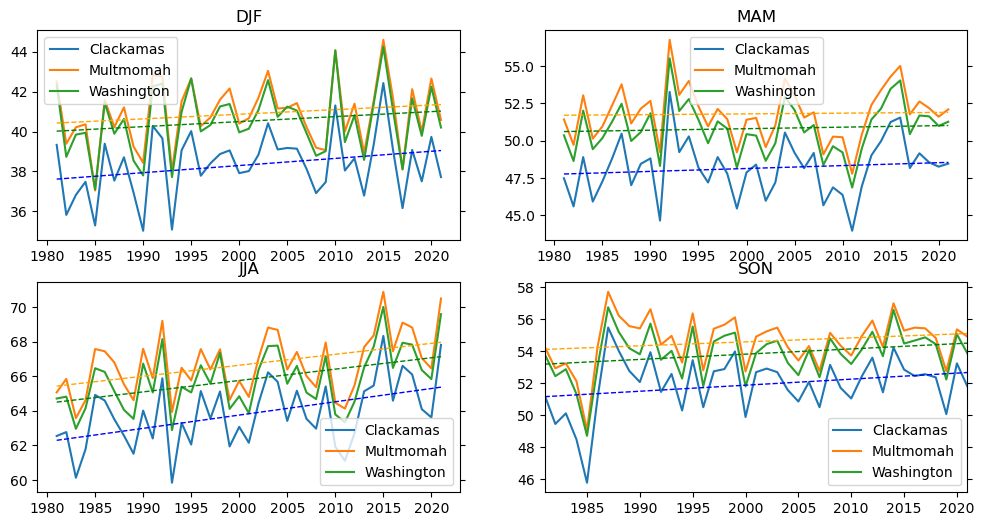

In [42]:
# the copy is a "deep copy" that any changes made in the original DataFrame will NOT be reflected in the copy.
df_tmean = df_tmax.copy()
df_tmean.Clackamas = (0.6*df_tmax.Clackamas + 0.4*df_tmin.Clackamas)* 9/5 + 32
df_tmean.Multmomah = (0.6*df_tmax.Multmomah + 0.4*df_tmin.Multmomah)* 9/5 + 32 
df_tmean.Washington = (0.6*df_tmax.Washington + 0.4*df_tmin.Washington)* 9/5 + 32 
plot_seasonal_ts(df_tmean, 'mean');